<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/denoised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.signal import find_peaks,butter, filtfilt
from scipy.fft import fft, ifft
from scipy.optimize import curve_fit
from scipy.fftpack import rfft, irfft, fftfreq, fft, rfftfreq
import pywt
from scipy.ndimage import gaussian_filter1d
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense,Dropout, LSTM, Bidirectional,Conv1D,Flatten
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

**Define functions**

In [4]:
def get_largest_value_array(Data, columns):
    # Subset the data frame to only include the specified columns
    sub_data = Data[columns]

    # Use the apply() function with the max() function to find the maximum value in each row of the subsetted data frame
    max_values = sub_data.apply(max, axis=1)

    # Create a new array that takes the maximum value from step 2 for each row of the original data frame
    max_array = np.array(max_values)
    
    return max_array
  
def get_smallest_value_array(Data, columns):
    # Subset the data frame to only include the specified columns
    sub_data = Data[columns]

    # Use the min() function to find the minimum value in each row of the subsetted data frame
    min_values = sub_data.min(axis=1)

    # Create a new array that takes the minimum value from step 2 for each row of the original data frame
    min_array = np.array(min_values)
    
    return min_array

def get_array_bo_greater_than_bc(Data):
    # Use np.where() to compare the "BO" and "BC" columns, return 1 if "BO" < "BC", and 0 otherwise
    result_array = np.where(Data["BO"] < Data["BC"], 1, 0)
    
    return result_array

def rolling_std(data, window_size):
    std_values = []
    
    for i in range(len(data) - window_size + 1):
        window = data[i:i+window_size]
        std = np.std(window)
        std_values.append(std)
    
    return std_values

def perform_fft(data, sample_rate):
    n = len(data)
    t = 1.0 / sample_rate

    # Perform FFT
    yf = np.fft.fft(data)
    freq = np.fft.fftfreq(n, t)[:n//2]
    amplitude = 2.0/n * np.abs(yf[:n//2])

    return freq, amplitude

def transform_scientific_notation(array):
    transformed_array = []
    
    for notation in array:
        value = float(notation)
        transformed_array.append(value)
    
    return transformed_array

def cycles_to_frequency(sample_rate, samples_per_cycle):
    period = samples_per_cycle / sample_rate  # Calculate the period
    frequency = 1 / period  # Calculate the frequency
    return frequency

def remove_cyclical_component(values, times, cycle):
    stdev_array = ta.stdev(values, 100)
    stdev_array = stdev_array.fillna(np.mean(stdev_array))
    
    scaled_val = values / stdev_array
    
    # Convert time to cyclical representation using sine and cosine
    time_sin = np.sin(2 * np.pi * times / cycle)
    time_cos = np.cos(2 * np.pi * times / cycle)
    
    # Combine sine and cosine representations
    time_features = np.column_stack((time_sin, time_cos))
    
    # Fit a regression model to the detrended values using cyclical time features
    regression_model = np.linalg.lstsq(time_features, scaled_val, rcond=None)[0]
    cyclical_component = np.dot(time_features, regression_model)
    
    # Remove the scaled cyclical component from the original values
    decycled_signal = (scaled_val - cyclical_component) * stdev_array
    
    return decycled_signal



def sine_func(t, amplitude, frequency, phase):
    return amplitude * np.sin(2 * np.pi * frequency * t + phase)

def fit_sine_wave_to_data(t, data, initial_guess):
    popt, pcov = curve_fit(sine_func, t, data, p0=initial_guess)
    amplitude, frequency, phase = popt
    fitted_data = sine_func(t, amplitude, frequency, phase)
    return fitted_data

def cumulative_sum(array):
    cum_sum = []
    current_sum = 0
    for element in array:
        current_sum += element
        cum_sum.append(current_sum)
    return cum_sum

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

def perform_dwt(array, wavelet='db1', level=1):
    # Perform DWT
    coeffs = pywt.wavedec(array, wavelet, level=level)

    # Extract approximation coefficients
    approx_coeffs = coeffs[0]

    # Reconstruct smoothed result
    smoothed_result = pywt.waverec([approx_coeffs], wavelet)

    return smoothed_result

def filter_signal(signal, threshold=1e8):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

def highpass_filter(data, cutoff_freq, sampling_freq, order=5):
    # Calculate the Nyquist frequency.
    nyquist_freq = 0.5 * sampling_freq
    # Calculate the normalized cutoff frequency.
    normalized_cutoff_freq = cutoff_freq / nyquist_freq
    # Create a Butterworth filter.
    b, a = butter(order, normalized_cutoff_freq, btype='high', analog=False)
    # Apply the filter to the data.
    filtered_data = filtfilt(b, a, data)
    # Return the filtered data.
    return filtered_data

# Function to convert DataFrame into sliding windows
def create_sliding_window(data, window_size):
    windows = []
    for i in range(len(data) - window_size + 1):
        window = data.iloc[i:i + window_size]
        windows.append(window.values)
    return np.array(windows)

**Load Data**

In [5]:
Data = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
Data['Date'] = pd.to_datetime(Data['Date'])
Data['Time'] = pd.to_datetime(Data['Time'])
print(Data)

            Date                Time       BO       BH       BL       BC  \
0     2005-05-02 2023-05-26 00:00:00  1.28520  1.28520  1.28400  1.28440   
1     2005-05-02 2023-05-26 01:00:00  1.28440  1.28480  1.28390  1.28420   
2     2005-05-02 2023-05-26 02:00:00  1.28430  1.28540  1.28410  1.28510   
3     2005-05-02 2023-05-26 03:00:00  1.28510  1.28590  1.28500  1.28510   
4     2005-05-02 2023-05-26 04:00:00  1.28520  1.28590  1.28490  1.28550   
...          ...                 ...      ...      ...      ...      ...   
93079 2020-04-29 2023-05-26 18:00:00  1.08620  1.08851  1.08611  1.08713   
93080 2020-04-29 2023-05-26 19:00:00  1.08711  1.08823  1.08659  1.08748   
93081 2020-04-29 2023-05-26 20:00:00  1.08747  1.08788  1.08691  1.08708   
93082 2020-04-29 2023-05-26 21:00:00  1.08708  1.08740  1.08699  1.08714   
93083 2020-04-29 2023-05-26 22:00:00  1.08728  1.08760  1.08727  1.08743   

           BCh       AO       AH       AL       AC      ACh  
0     -0.00080  1.28540  

**Extract time information**

In [6]:
Date = pd.DataFrame()

Date['day'] = Data['Date'].dt.day
Date['month'] = Data['Date'].dt.month
Date['weekday'] = Data['Date'].dt.weekday
Date['hour_of_day'] = Data['Time'].dt.hour

print(Date)

       day  month  weekday  hour_of_day
0        2      5        0            0
1        2      5        0            1
2        2      5        0            2
3        2      5        0            3
4        2      5        0            4
...    ...    ...      ...          ...
93079   29      4        2           18
93080   29      4        2           19
93081   29      4        2           20
93082   29      4        2           21
93083   29      4        2           22

[93084 rows x 4 columns]


**Candle stick and other chart info**

In [7]:
Shape = pd.DataFrame()

abs_diff_array = np.abs(Data['BH'] - Data['BL'])

updown_array = get_array_bo_greater_than_bc(Data)

max_array = get_largest_value_array(Data,["BC", "BO"])
min_array = get_smallest_value_array(Data,["BC", "BO"])

tp_array = (Data['BH']-min_array)/abs_diff_array
bp_array = (Data['BH']-max_array)/abs_diff_array

RelChange = Data['BC'] - Data['BO']

Shape["Direction"] = updown_array
Shape["Bottom_Point"] = bp_array
Shape["Top_Point"] = tp_array
Shape["Relative_Change"] = RelChange
Shape["Size"] = abs_diff_array




print(Shape)

       Direction  Bottom_Point  Top_Point  Relative_Change     Size
0              0      0.000000   0.666667         -0.00080  0.00120
1              0      0.444444   0.666667         -0.00020  0.00090
2              1      0.230769   0.846154          0.00080  0.00130
3              0      0.888889   0.888889          0.00000  0.00090
4              1      0.400000   0.700000          0.00030  0.00100
...          ...           ...        ...              ...      ...
93079          1      0.575000   0.962500          0.00093  0.00240
93080          1      0.457317   0.682927          0.00037  0.00164
93081          0      0.422680   0.824742         -0.00039  0.00097
93082          1      0.634146   0.780488          0.00006  0.00041
93083          1      0.515152   0.969697          0.00015  0.00033

[93084 rows x 5 columns]


(70000.0, 80200.0)

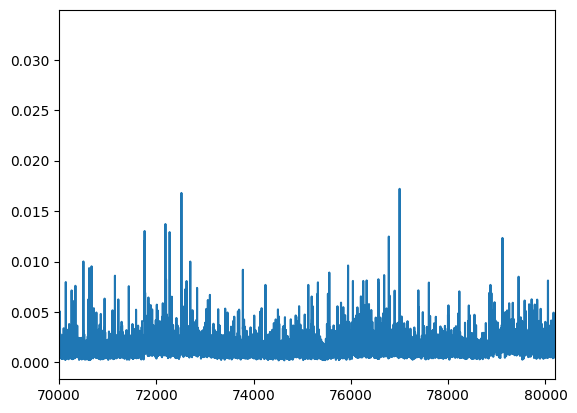

In [8]:

times = Date["hour_of_day"]
values = Shape["Size"]
#values = Shape["Relative_Change"]
values = np.abs(values)

plt.plot(values)

plt.xlim(70000,80200)


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-0.002, 0.005)

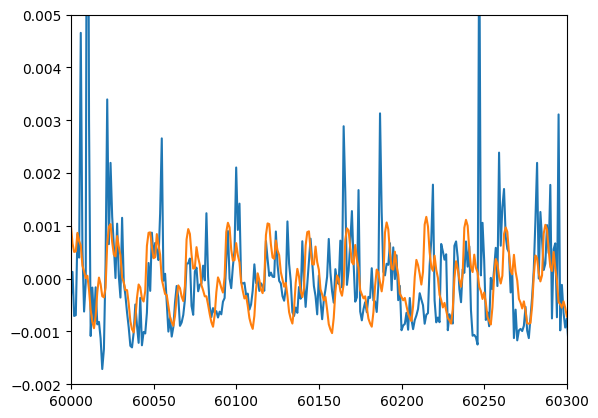

In [9]:

values = np.array(values)
values = values-np.mean(values)



# Apply a high-pass filter to the data.
cutoff_freq = 5  # Hz
sampling_freq = 1000  # Hz
filtered_data = highpass_filter(values, cutoff_freq, sampling_freq)


threshold = .8
y_fft = fft(filtered_data)
y_soft = pywt.threshold(y_fft, value=threshold, mode='soft')
y_denoised = ifft(y_soft)

plt.plot(filtered_data)
plt.plot(y_denoised)


plt.xlim(60000,60300)
plt.ylim(-.002,.005)


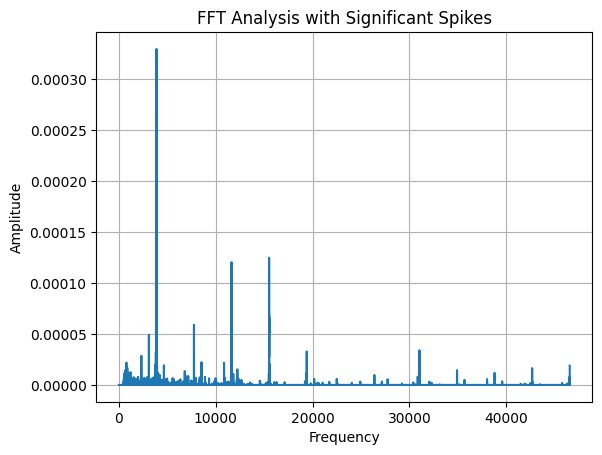

In [10]:
data = y_denoised

sample_rate = len(data) # Assuming unit time interval between data points

meanrmv = data - np.mean(data)

freq, amplitude = perform_fft(data, sample_rate)




# Plotting
plt.plot(freq, amplitude)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('FFT Analysis with Significant Spikes')
plt.grid(True)
plt.show()

In [11]:
# Create a MinMaxScaler object
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
pt = PowerTransformer(method='yeo-johnson')


y_denoised = np.array(y_denoised)
y_denoised = np.real(y_denoised).astype(float)

y_denoised = pd.DataFrame(y_denoised, columns=["Target"])
new = pd.concat([Date, Shape, y_denoised], axis=1)
new.dropna(axis=0,inplace=True) # Note that we need to call the method with parentheses to apply the changes
new = new.reset_index(drop=True)


# Scale all columns and assign them back to the DataFrame
new[new.columns] = scaler.fit_transform(new[new.columns])

target = new.pop("Target")

df_transformed = pt.fit_transform(new)

# Convert the transformed data to a new DataFrame
df_transformed = pd.DataFrame(df_transformed, columns=new.columns)


print(target)
print(df_transformed)

0        0.340397
1        0.310038
2        0.252057
3        0.194185
4        0.169277
           ...   
93075    0.369353
93076    0.327957
93077    0.300420
93078    0.275573
93079    0.303806
Name: Target, Length: 93080, dtype: float64
            day     month   weekday  hour_of_day  Direction  Bottom_Point  \
0     -1.610143 -0.418775 -1.459601    -1.710356  -1.000494     -1.672881   
1     -1.610143 -0.418775 -1.459601    -1.551685  -1.000494      0.865402   
2     -1.610143 -0.418775 -1.459601    -1.394691   0.999506     -0.097647   
3     -1.610143 -0.418775 -1.459601    -1.239292  -1.000494      2.102521   
4     -1.610143 -0.418775 -1.459601    -1.085411   0.999506      0.692277   
...         ...       ...       ...          ...        ...           ...   
93075  1.476374 -0.718091  0.056353     0.940833   0.999506      1.310772   
93076  1.476374 -0.718091  0.056353     1.078075   0.999506      0.913325   
93077  1.476374 -0.718091  0.056353     1.214486  -1.000494      

In [12]:
# Define parameters
window_size = 48

# Convert input and target DataFrames to sliding windows
input_data = create_sliding_window(df_transformed, window_size)
target_data = create_sliding_window(target, window_size)
target_aligned = target[window_size - 1:]

X_train, X_test, y_train, y_test = train_test_split(input_data, target_aligned, test_size=0.2,shuffle=False)



In [39]:
reg = l2(.01)

# create a sequential model
model = tf.keras.Sequential()
model.add(Conv1D(120,kernel_size = 7))
model.add(Dropout(.2))
model.add(Conv1D(40,kernel_size = 7))
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(30,activation='gelu'))
model.add(Dropout(.2))
model.add(Dense(10,activation='gelu'))
model.add(Dropout(.2))
model.add(Dense(1,activation='linear'))

# compile the model with categorical crossentropy loss and Adam optimizer
model.compile(loss='mse', optimizer='adam',metrics='MeanAbsoluteError')

In [40]:
history = model.fit(X_train,y_train,epochs=100,batch_size=32,validation_data=(X_test,y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Epoch 1/100
2326/2326 [==============================] - 55s 23ms/step - loss: 0.0163 - mean_absolute_error: 0.0895 - val_loss: 0.0028 - val_mean_absolute_error: 0.0417
Epoch 2/100
2326/2326 [==============================] - 52s 22ms/step - loss: 0.0061 - mean_absolute_error: 0.0603 - val_loss: 0.0024 - val_mean_absolute_error: 0.0384
Epoch 3/100
2326/2326 [==============================] - 55s 24ms/step - loss: 0.0059 - mean_absolute_error: 0.0593 - val_loss: 0.0029 - val_mean_absolute_error: 0.0424
Epoch 4/100
2326/2326 [==============================] - 50s 22ms/step - loss: 0.0061 - mean_absolute_error: 0.0601 - val_loss: 0.0036 - val_mean_absolute_error: 0.0467
Epoch 5/100
2326/2326 [==============================] - 52s 22ms/step - loss: 0.0061 - mean_absolute_error: 0.0601 - val_loss: 0.0032 - val_mean_absolute_error: 0.0448
Epoch 6/100
2326/2326 [==============================] - 50s 22ms/step - loss: 0.0060 - mean_absolute_error: 0.0592 - val_loss: 0.0033 - val_mean_absolute_

KeyboardInterrupt: ignored

In [15]:
y_pred = model.predict(X_test)



582/582 [==============================] - 25s 38ms/step


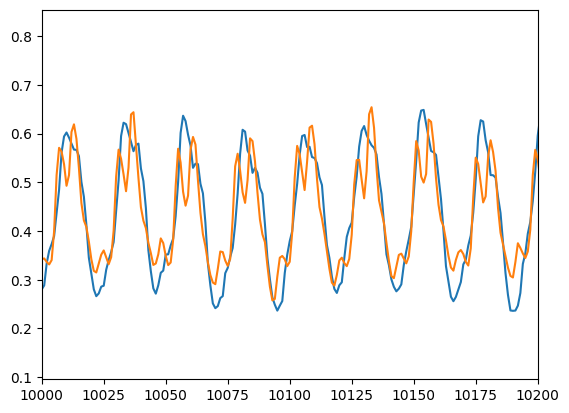

In [25]:
#y_pred = y_pred.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
# Plot the predictions

xstart = 10000
xadd = 200

plt.plot(y_test)
plt.plot(y_pred)
plt.xlim(xstart,xstart+xadd)
plt.show()
